In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_6(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2,dropout3,dropout4):
        super(DNN_6, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)

        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout3(x)

        x = torch.relu(self.layer4(x))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整

    # モデル定義
    model = DNN_6(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs > 0.49).float()  
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:09:28,391] A new study created in memory with name: no-name-4176f204-1d6c-4fd6-ad94-2e65181ea183
/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:10:54,358] Trial 0 finished with value: 0.17635143244924836 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.05, 'dropout3': 0.05, 'dropout4': 0.0, 'learning_rate': 0.0009113035802664196}. Best is trial 0 with value: 0.17635143244924836.


Early stopping at epoch 29
Final MCC: 0.1764


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:11:56,664] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0034229803553909787}. Best is trial 0 with value: 0.17635143244924836.


Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:13:23,501] Trial 2 finished with value: 0.05249283197298709 and parameters: {'dropout1': 0.25, 'dropout2': 0.25, 'dropout3': 0.1, 'dropout4': 0.45, 'learning_rate': 0.002055133916190706}. Best is trial 0 with value: 0.17635143244924836.


Early stopping at epoch 28
Final MCC: 0.0525


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:16:53,817] Trial 3 finished with value: 0.32876875325808125 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.45, 'learning_rate': 0.00010529855553305321}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 70
Final MCC: 0.3288


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:17:29,840] Trial 4 finished with value: 0.2850245223659899 and parameters: {'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'dropout3': 0.2, 'dropout4': 0.2, 'learning_rate': 0.0028323771936837163}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 11
Final MCC: 0.2850


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:18:24,658] Trial 5 finished with value: 0.32574704291377815 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.15000000000000002, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00047290850682806304}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 16
Final MCC: 0.3257


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:19:08,747] Trial 6 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'dropout3': 0.1, 'dropout4': 0.4, 'learning_rate': 0.009647526619809346}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:20:30,322] Trial 7 finished with value: 0.31021820500027975 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'dropout3': 0.5, 'dropout4': 0.25, 'learning_rate': 0.0003360283827981226}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 23
Final MCC: 0.3102


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:20:33,955] Trial 8 pruned. 
[I 2024-12-04 16:20:37,465] Trial 9 pruned. 
[I 2024-12-04 16:22:34,820] Trial 10 finished with value: 0.27800760235913036 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.45, 'learning_rate': 0.0001375149434029498}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 34
Final MCC: 0.2780


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:25:30,147] Trial 11 finished with value: 0.3127037834952593 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dropout3': 0.30000000000000004, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00010706718253061178}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 50
Final MCC: 0.3127


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:28:04,087] Trial 12 finished with value: 0.01967582419901983 and parameters: {'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'dropout3': 0.25, 'dropout4': 0.5, 'learning_rate': 0.0003234878287904902}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 44
Final MCC: 0.0197


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:28:07,572] Trial 13 pruned. 
[I 2024-12-04 16:30:08,496] Trial 14 finished with value: 0.3219863429118815 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.5, 'learning_rate': 0.00020802887258685197}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 33
Final MCC: 0.3220


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:30:12,263] Trial 15 pruned. 
[I 2024-12-04 16:31:35,493] Trial 16 finished with value: 0.2670740987867434 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dropout3': 0.2, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00021653622313579286}. Best is trial 3 with value: 0.32876875325808125.


Early stopping at epoch 23
Final MCC: 0.2671


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:31:39,122] Trial 17 pruned. 
[I 2024-12-04 16:31:42,738] Trial 18 pruned. 
[I 2024-12-04 16:34:39,439] Trial 19 finished with value: 0.3401680257083045 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00016591983542101353}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 48
Final MCC: 0.3402


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:36:46,888] Trial 20 finished with value: 0.3182192318053801 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00016600218708147697}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 34
Final MCC: 0.3182


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:41:20,617] Trial 21 finished with value: 0.30340380493549934 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00010564605933712874}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 72
Final MCC: 0.3034


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:41:24,313] Trial 22 pruned. 
[I 2024-12-04 16:41:27,997] Trial 23 pruned. 
[I 2024-12-04 16:44:50,937] Trial 24 finished with value: 0.3073093301386144 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'dropout3': 0.15000000000000002, 'dropout4': 0.25, 'learning_rate': 0.00013885616971142162}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 54
Final MCC: 0.3073


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:44:54,657] Trial 25 pruned. 
[I 2024-12-04 16:44:58,521] Trial 26 pruned. 
[I 2024-12-04 16:45:02,313] Trial 27 pruned. 
[I 2024-12-04 16:46:56,039] Trial 28 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.5, 'learning_rate': 0.00016195367323604975}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:46:59,697] Trial 29 pruned. 
[I 2024-12-04 16:49:07,723] Trial 30 finished with value: 0.07337993857053428 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.45, 'learning_rate': 0.0001957523939107067}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 34
Final MCC: 0.0734


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:50:30,258] Trial 31 finished with value: 0.12420766160787448 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.5, 'learning_rate': 0.00024710168817899486}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 21
Final MCC: 0.1242


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:52:54,458] Trial 32 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.5, 'learning_rate': 0.00010606567444150131}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 37
Final MCC: 0.0000


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:52:58,320] Trial 33 pruned. 
[I 2024-12-04 16:53:02,184] Trial 34 pruned. 
[I 2024-12-04 16:55:23,090] Trial 35 finished with value: 0.24397045524847633 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'dropout3': 0.2, 'dropout4': 0.4, 'learning_rate': 0.00013611949264612772}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 36
Final MCC: 0.2440


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:55:26,866] Trial 36 pruned. 
[I 2024-12-04 16:55:30,649] Trial 37 pruned. 
[I 2024-12-04 16:55:34,442] Trial 38 pruned. 
[I 2024-12-04 16:59:28,297] Trial 39 finished with value: 0.16718283108591322 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.15000000000000002, 'dropout4': 0.45, 'learning_rate': 0.00027536926639790696}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 61
Final MCC: 0.1672


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:59:32,139] Trial 40 pruned. 
[I 2024-12-04 17:02:19,327] Trial 41 finished with value: 0.31112351834242324 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.1, 'learning_rate': 0.0001656877977823098}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 43
Final MCC: 0.3111


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:06:01,684] Trial 42 finished with value: 0.2645751311064591 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00012207770723687622}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 57
Final MCC: 0.2646


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:07:53,907] Trial 43 finished with value: 0.060678496982207536 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00018279627784122885}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 28
Final MCC: 0.0607


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:07:57,828] Trial 44 pruned. 
[I 2024-12-04 17:11:50,599] Trial 45 finished with value: 0.28682760706051597 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 0.00027302245885907887}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 65
Final MCC: 0.2868


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:13:48,011] Trial 46 finished with value: 0.3149315163115528 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.5, 'learning_rate': 0.0001606461969422278}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 32
Final MCC: 0.3149


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:13:51,482] Trial 47 pruned. 
[I 2024-12-04 17:16:58,888] Trial 48 finished with value: 0.23350726947740727 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00012258412073693742}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 58
Final MCC: 0.2335


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:18:51,965] Trial 49 finished with value: 0.0719065237942896 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.2, 'dropout4': 0.45, 'learning_rate': 0.00020561333938260343}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 35
Final MCC: 0.0719


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:21:20,161] Trial 50 finished with value: 0.3276033597166953 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.35000000000000003, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00010103961166714404}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 46
Final MCC: 0.3276


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:24:01,937] Trial 51 finished with value: 0.3144452433120083 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.35000000000000003, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00010462150061026685}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 50
Final MCC: 0.3144


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:27:20,904] Trial 52 finished with value: 0.1984621082065641 and parameters: {'dropout1': 0.5, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00013061607580264764}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 62
Final MCC: 0.1985


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:27:24,175] Trial 53 pruned. 
[I 2024-12-04 17:27:27,423] Trial 54 pruned. 
[I 2024-12-04 17:29:59,415] Trial 55 finished with value: 0.31066390097531804 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00010456424834256949}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 46
Final MCC: 0.3107


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:30:02,665] Trial 56 pruned. 
[I 2024-12-04 17:35:02,489] Trial 57 finished with value: 0.14215828201016295 and parameters: {'dropout1': 0.5, 'dropout2': 0.45, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.0001221593307246036}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 96
Final MCC: 0.1422


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:35:05,408] Trial 58 pruned. 
[I 2024-12-04 17:35:08,413] Trial 59 pruned. 
[I 2024-12-04 17:35:11,386] Trial 60 pruned. 
[I 2024-12-04 17:38:06,087] Trial 61 finished with value: 0.14048279070968459 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.5, 'learning_rate': 0.00015498876233588775}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 59
Final MCC: 0.1405


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:38:09,123] Trial 62 pruned. 
[I 2024-12-04 17:38:12,170] Trial 63 pruned. 
[I 2024-12-04 17:40:53,923] Trial 64 finished with value: 0.23350726947740727 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'dropout3': 0.25, 'dropout4': 0.45, 'learning_rate': 0.00014627670898613305}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 54
Final MCC: 0.2335


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:42:22,426] Trial 65 finished with value: 0.29433848178860794 and parameters: {'dropout1': 0.4, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.5, 'learning_rate': 0.00011651264081776822}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 29
Final MCC: 0.2943


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:42:25,318] Trial 66 pruned. 
[I 2024-12-04 17:42:28,191] Trial 67 pruned. 
[I 2024-12-04 17:42:31,172] Trial 68 pruned. 
[I 2024-12-04 17:42:34,222] Trial 69 pruned. 
[I 2024-12-04 17:42:37,354] Trial 70 pruned. 
[I 2024-12-04 17:44:56,604] Trial 71 finished with value: 0.32011378178572664 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.35000000000000003, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00011233388755975536}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 47
Final MCC: 0.3201


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:44:59,515] Trial 72 pruned. 
[I 2024-12-04 17:46:48,002] Trial 73 finished with value: 0.3219863429118815 and parameters: {'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00016951772017042825}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 37
Final MCC: 0.3220


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:46:50,973] Trial 74 pruned. 
[I 2024-12-04 17:49:17,848] Trial 75 finished with value: 0.20761904761904762 and parameters: {'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00011769044397649482}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 50
Final MCC: 0.2076


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:49:20,852] Trial 76 pruned. 
[I 2024-12-04 17:51:10,144] Trial 77 finished with value: 0.3182192318053801 and parameters: {'dropout1': 0.45, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00016883105975293875}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 37
Final MCC: 0.3182


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:51:13,043] Trial 78 pruned. 
[I 2024-12-04 17:51:15,988] Trial 79 pruned. 
[I 2024-12-04 17:51:18,888] Trial 80 pruned. 
[I 2024-12-04 17:51:21,845] Trial 81 pruned. 
[I 2024-12-04 17:51:24,765] Trial 82 pruned. 
[I 2024-12-04 17:51:27,678] Trial 83 pruned. 
[I 2024-12-04 17:54:35,294] Trial 84 finished with value: 0.32963901647465516 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00011509674012565804}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 64
Final MCC: 0.3296


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:56:18,604] Trial 85 finished with value: 0.3020299100761005 and parameters: {'dropout1': 0.4, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.35000000000000003, 'learning_rate': 0.0001383166383348234}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 34
Final MCC: 0.3020


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:59:16,922] Trial 86 finished with value: 0.33902621655294457 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 0.00011189424224287243}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 59
Final MCC: 0.3390


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:59:20,012] Trial 87 pruned. 
[I 2024-12-04 18:02:55,733] Trial 88 finished with value: 0.3219863429118815 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.2, 'learning_rate': 0.00010089722187945118}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 72
Final MCC: 0.3220


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 18:06:02,840] Trial 89 finished with value: 0.14498416521560314 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.2, 'learning_rate': 0.00012451024931100027}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 59
Final MCC: 0.1450


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 18:06:06,219] Trial 90 pruned. 
[I 2024-12-04 18:08:28,936] Trial 91 finished with value: 0.31066390097531804 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.25, 'learning_rate': 0.00010052843572604175}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 47
Final MCC: 0.3107


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 18:08:31,916] Trial 92 pruned. 
[I 2024-12-04 18:10:54,541] Trial 93 finished with value: 0.3089056477310863 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'dropout3': 0.45, 'dropout4': 0.25, 'learning_rate': 0.00011305926644119207}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 45
Final MCC: 0.3089


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 18:10:57,966] Trial 94 pruned. 
[I 2024-12-04 18:13:39,720] Trial 95 finished with value: 0.3225307463503984 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00014861569021867402}. Best is trial 19 with value: 0.3401680257083045.


Early stopping at epoch 51
Final MCC: 0.3225


/tmp/ipykernel_282182/2540710613.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 18:13:43,263] Trial 96 pruned. 
[I 2024-12-04 18:13:46,752] Trial 97 pruned. 
[I 2024-12-04 18:13:49,559] Trial 98 pruned. 
[I 2024-12-04 18:13:52,483] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00016591983542101353}
Best Validation F1:  0.3401680257083045


Epoch [1/100], Loss: 0.6685
Epoch [1/100], Train Loss: 0.6685, Val Loss: 0.6477
Epoch [2/100], Loss: 0.6396
Epoch [2/100], Train Loss: 0.6396, Val Loss: 0.5996
Epoch [3/100], Loss: 0.6143
Epoch [3/100], Train Loss: 0.6143, Val Loss: 0.5857
Epoch [4/100], Loss: 0.5986
Epoch [4/100], Train Loss: 0.5986, Val Loss: 0.5820
Epoch [5/100], Loss: 0.5929
Epoch [5/100], Train Loss: 0.5929, Val Loss: 0.5797
Epoch [6/100], Loss: 0.5947
Epoch [6/100], Train Loss: 0.5947, Val Loss: 0.5781
Epoch [7/100], Loss: 0.5876
Epoch [7/100], Train Loss: 0.5876, Val Loss: 0.5763
Epoch [8/100], Loss: 0.5800
Epoch [8/100], Train Loss: 0.5800, Val Loss: 0.5741
Epoch [9/100], Loss: 0.5837
Epoch [9/100], Train Loss: 0.5837, Val Loss: 0.5717
Epoch [10/100], Loss: 0.5773
Epoch [10/100], Train Loss: 0.5773, Val Loss: 0.5706
Epoch [11/100], Loss: 0.5722
Epoch [11/100], Train Loss: 0.5722, Val Loss: 0.5699
Epoch [12/100], Loss: 0.5754
Epoch [12/100], Train Loss: 0.5754, Val Loss: 0.5679
Epoch [13/100], Loss: 0.5695
Epoch

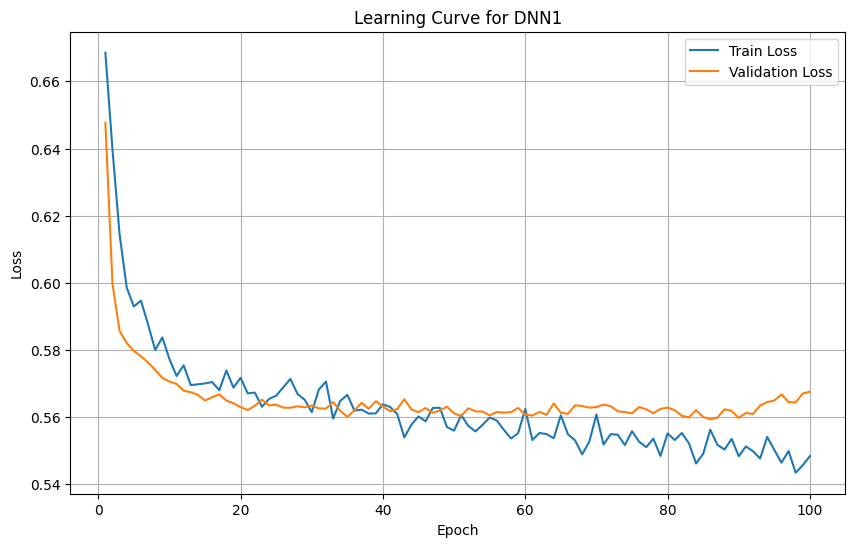

In [13]:
best_params=study.best_params
model = DNN_6(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.63%
Precision: 0.4560
Recall: 0.5044
F1 Score: 0.4790
Matthews Correlation Coefficient: 0.1240
Specificity: 0.6215


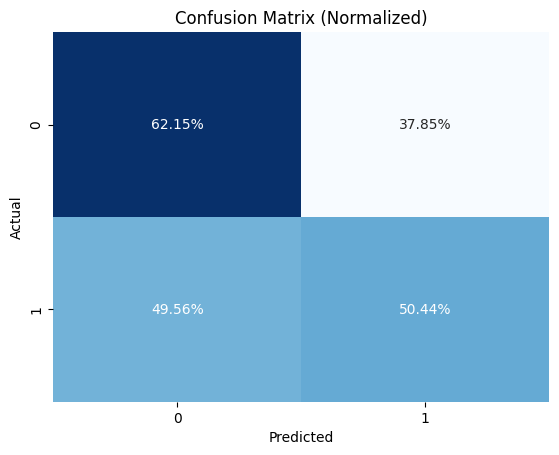

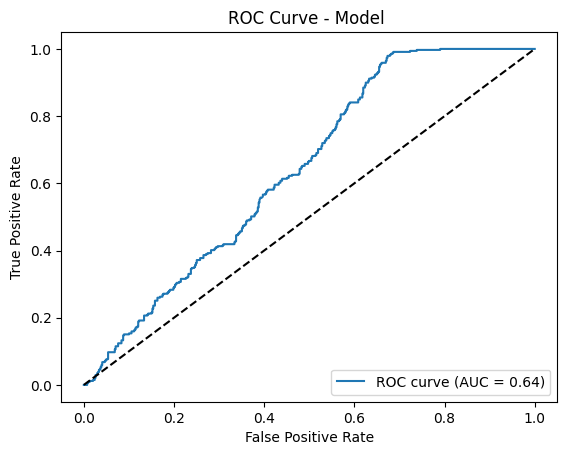

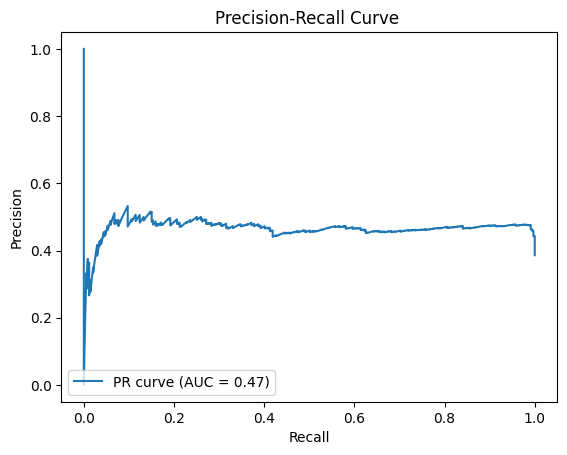

In [14]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_6.pth')

